# Wet day frequency

Assessment of model percentage of wet days per season bias over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [73]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [74]:
def calc_wet_freq(da, var):
    """Calculate the percentage of wet days per season (DJF, MAM, JJA, SON)"""
    threshold = 1
    wet_days = da.where(da>threshold).groupby('time.season').count('time')
    total_days = da.groupby('time.season').count('time')
    wet_day_freq = (wet_days / total_days) * 100
    wet_day_freq_djf = wet_day_freq.sel(season='DJF')
    wet_day_freq_mam = wet_day_freq.sel(season='MAM')
    wet_day_freq_jja = wet_day_freq.sel(season='JJA')
    wet_day_freq_son = wet_day_freq.sel(season='SON')
    return wet_day_freq_djf, wet_day_freq_mam, wet_day_freq_jja, wet_day_freq_son     


In [75]:
def get_data(var, rcm):
    """Get data needed for the evaluation"""

    assert rcm in ['BOM-BARPA-R', 'UQ-DES-CCAM-2105']
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )   
    da_gcm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        'GCM',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_raw = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'ecdfm',
        'task-historical',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    # TODO: Add additional bias correction methods as data becomes available 

    return da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm

In [76]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, season):
    """Plot the mean bias for a particular model"""
    
    wdf_obs1, wdf_obs2, wdf_obs3, wdf_obs4 = calc_wet_freq(da_obs, var)
    wdf_model1, wdf_model2, wdf_model3, wdf_model4 = calc_wet_freq(da_model, var)

    if season == 'DJF':
        bias = wdf_model1 - wdf_obs1
    elif season == 'MAM':
        bias = wdf_model2 - wdf_obs2
    elif season == 'JJA':
        bias = wdf_model3 - wdf_obs3
    elif season == 'SON':
        bias = wdf_model4 - wdf_obs4
    else:
        print('Invalid season')
        return
    
    units = '%' if var == 'pr' else da_model.attrs['units']
    
    im = bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14) 


In [77]:
def plot_comparison(var, rcm, cmap, levels):
    """Plot the complete comparison"""

    da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm = get_data(var, rcm)

    seasons= ['DJF', 'MAM', 'JJA', 'SON']
        
    rows, cols = len(seasons), 3  
    
    fig, axs = plt.subplots(rows, cols, figsize=[24, 6*rows], subplot_kw={'projection': ccrs.PlateCarree()})
    
    for row, season in enumerate(seasons):

        ax1 = axs[row, 0]
        ax2 = axs[row, 1]
        ax3 = axs[row, 2]

        # Plot GCM bias
        plot_mean_bias(ax1, da_obs, da_gcm, 'pr', cmap, levels, 'CSIRO-ACCESS-ESM1-5', season)
        ax1.set_title(f'CSIRO-ACCESS-ESM1-5 ({season})', fontsize=16)

        # Plot RCM raw bias
        plot_mean_bias(ax2, da_obs, da_rcm_raw, 'pr', cmap, levels, f'{rcm} (raw)', season)
        ax2.set_title(f'{rcm} (raw) ({season})', fontsize=16)

        # Plot RCM bias corrected bias
        plot_mean_bias(ax3, da_obs, da_rcm_ecdfm, 'pr', cmap, levels, f'{rcm} (ecdfm)', season)
        ax3.set_title(f'{rcm} (ecdfm) ({season})', fontsize=16)
    
    long_name = da_rcm_raw.attrs['long_name']
    plt.suptitle(f' Wet-day frequency bias (model minus obs) for different seasons in the 2000-2019 {long_name}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


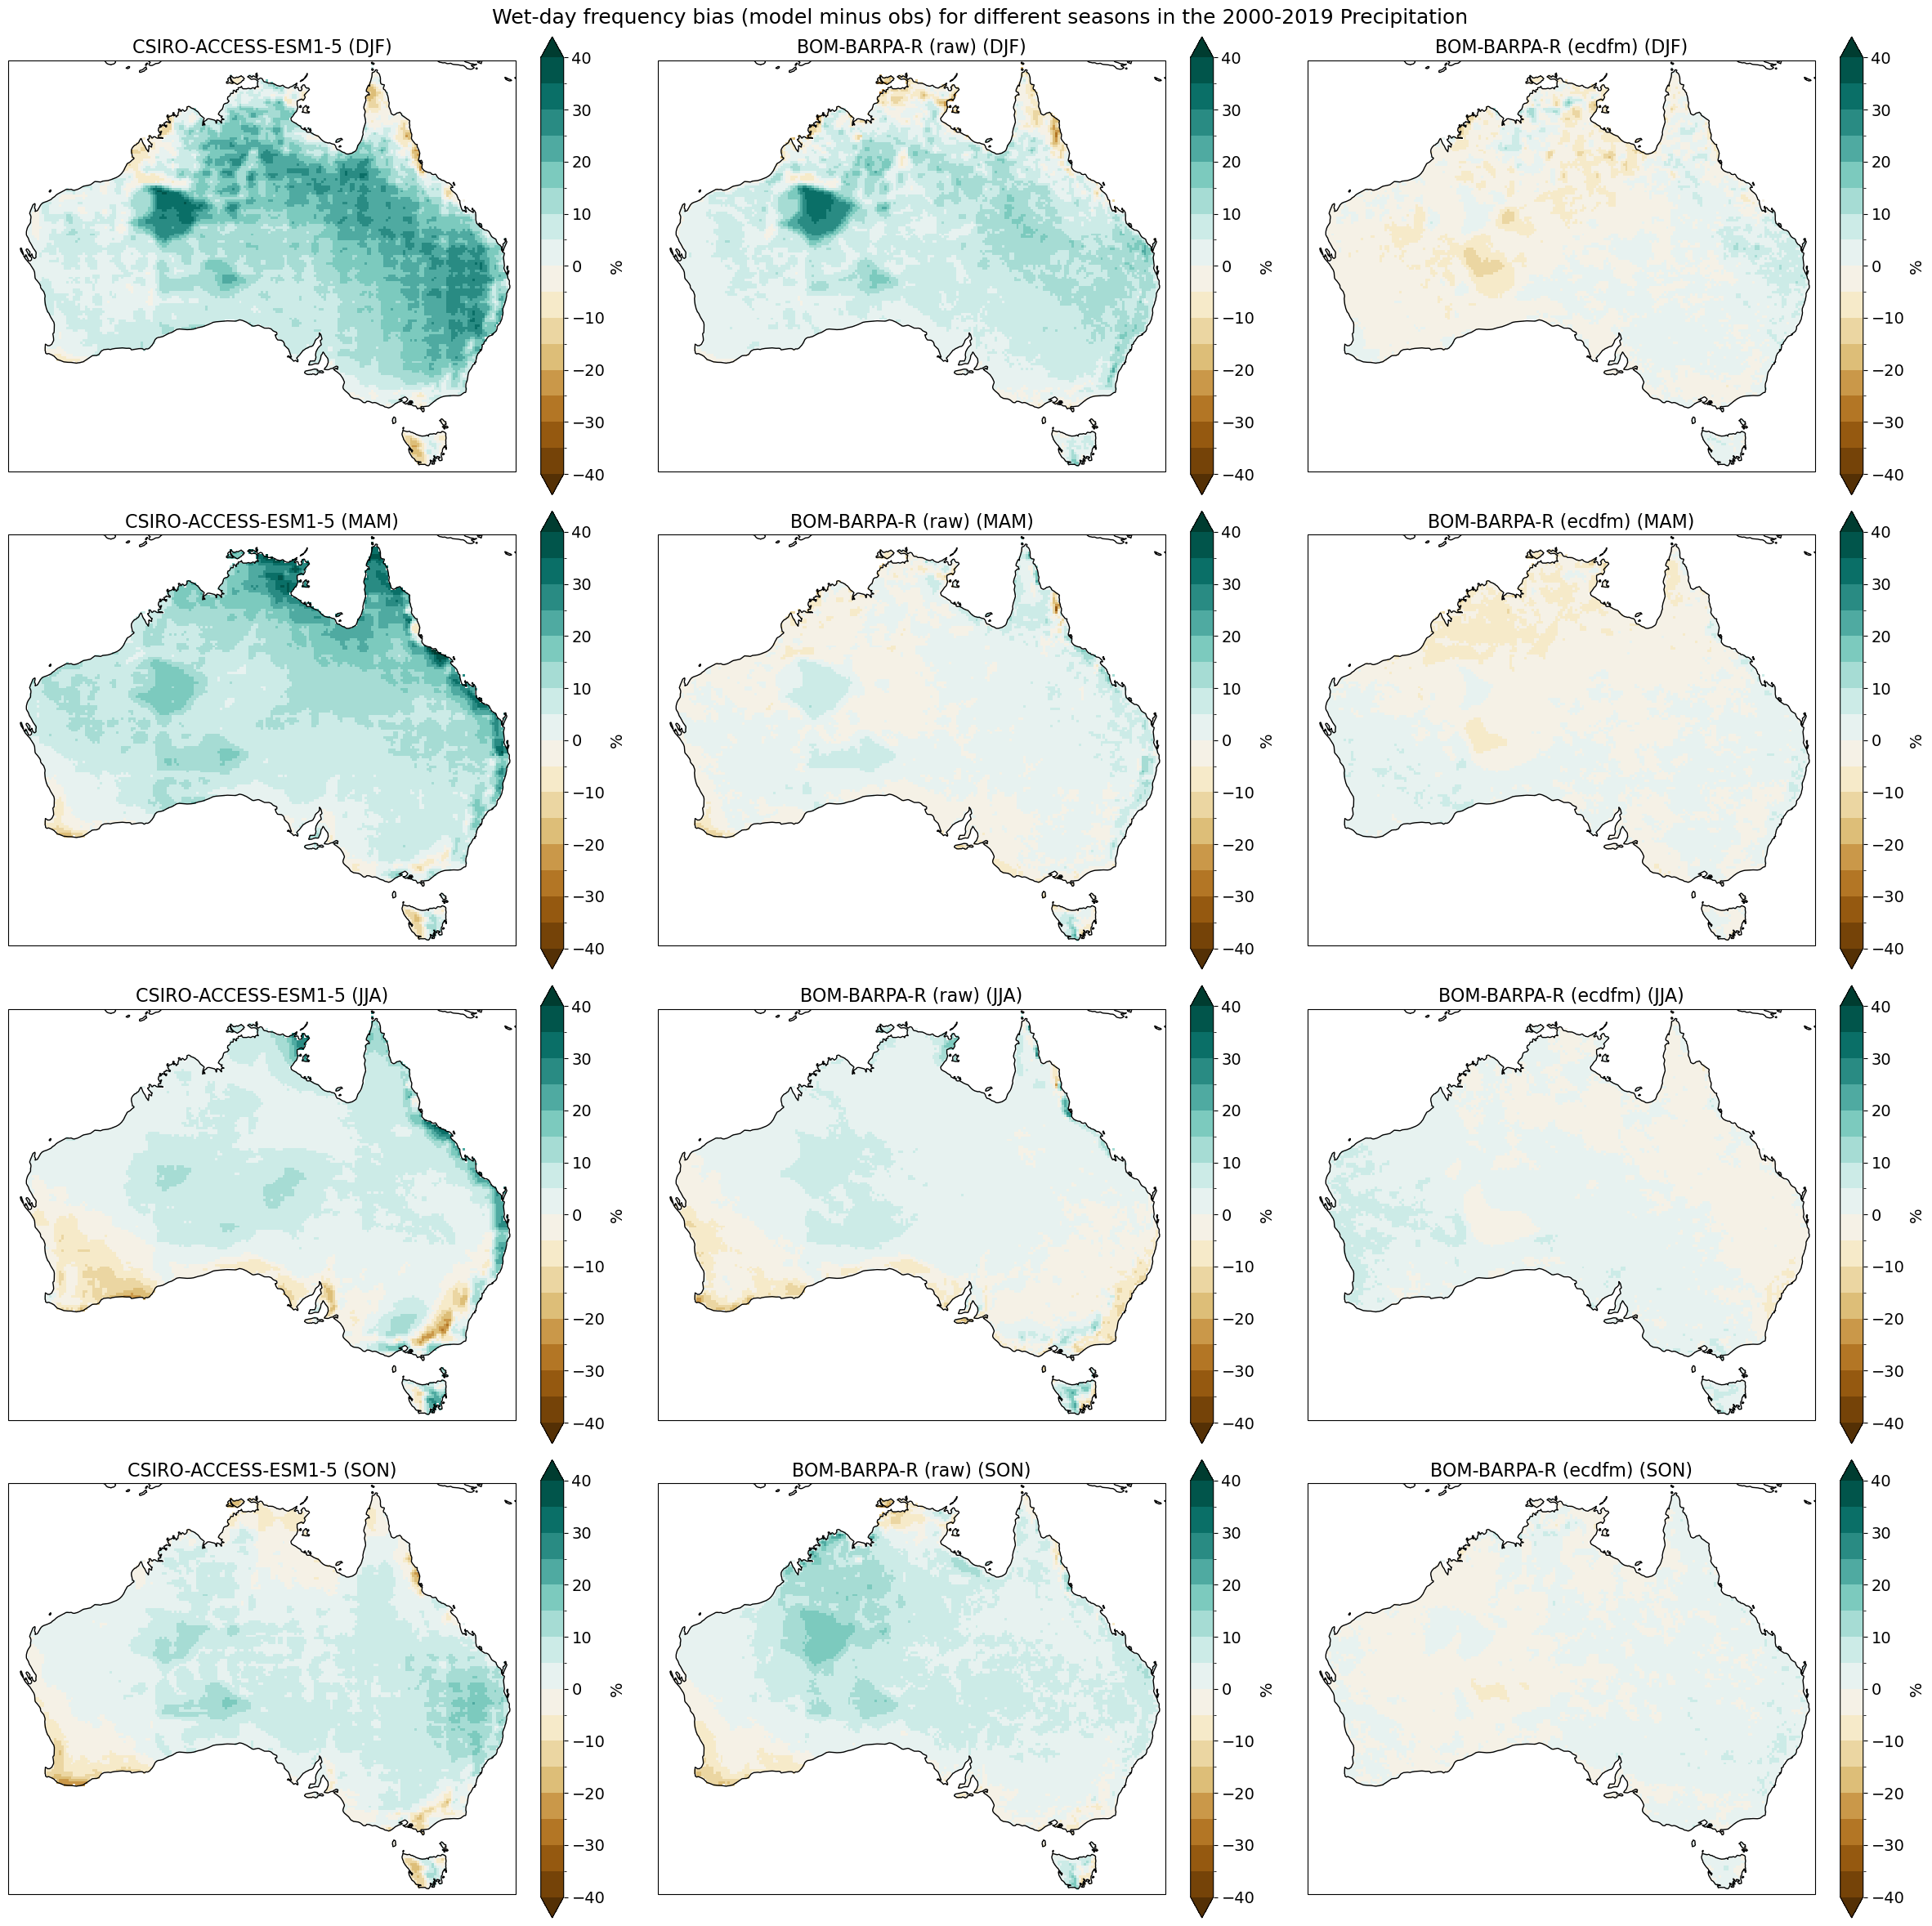

In [78]:
plot_comparison('pr', 'BOM-BARPA-R', 'BrBG', np.arange(-40, 40.1, 5))

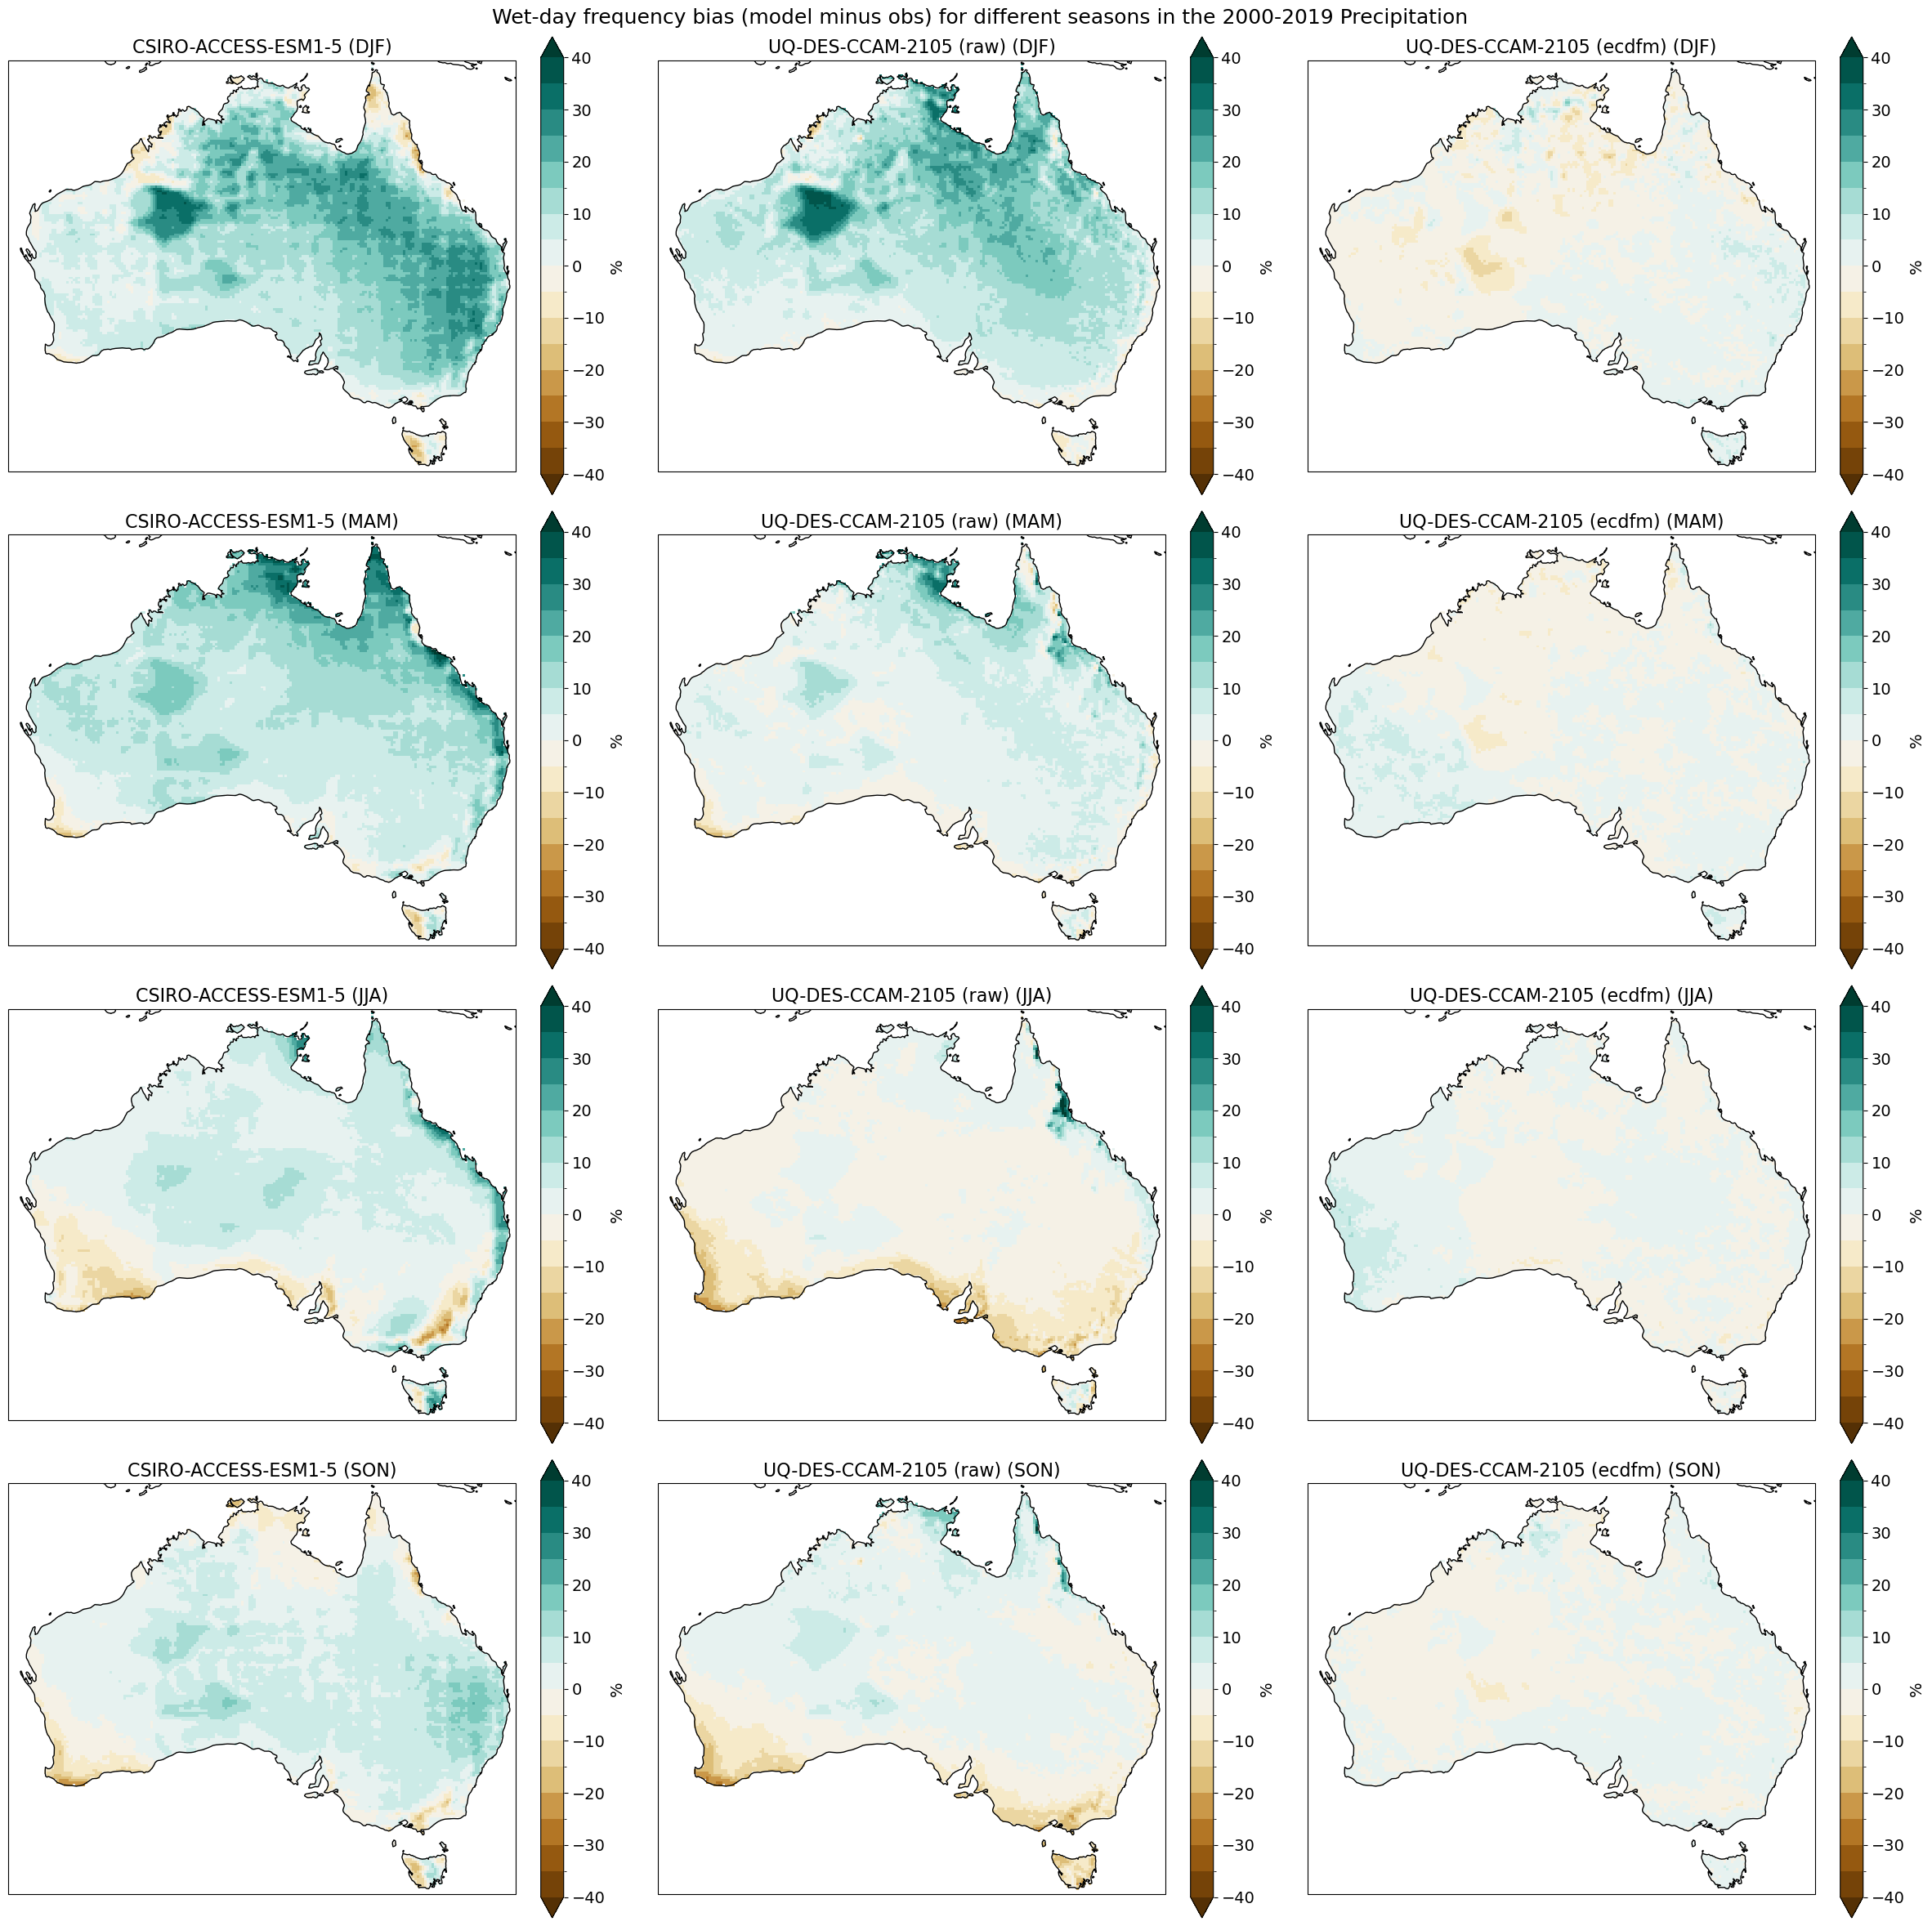

In [79]:
plot_comparison('pr', 'UQ-DES-CCAM-2105', 'BrBG', np.arange(-40, 40.1, 5))